In [1]:
%matplotlib inline

In [2]:
! pwd

/data/srlab1/TCAT/Analysis/PerDataset/HaoEtAl


In [3]:
import scanpy  as sc
import muon as mu
import numpy as np
import matplotlib.pyplot as plt
from cnmf import Preprocess
import pandas as pd


sc.logging.print_versions()

/PHShome/mc1070/anaconda3/envs/cnmf_env2v2/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


-----
anndata     0.8.0
scanpy      1.9.1
-----
PIL                 9.1.0
backcall            0.2.0
beta_ufunc          NA
binom_ufunc         NA
cached_property     1.5.2
cffi                1.15.0
cloudpickle         2.2.1
cnmf                NA
colorama            0.4.4
cycler              0.10.0
cython_runtime      NA
dask                2022.02.0
dateutil            2.8.2
debugpy             1.6.0
decorator           5.1.1
defusedxml          0.7.1
entrypoints         0.4
fastcluster         1.2.6
fsspec              2023.1.0
h5py                3.6.0
harmonypy           NA
igraph              0.9.9
ipykernel           6.13.0
ipython_genutils    0.2.0
jedi                0.18.1
jinja2              3.1.1
joblib              1.1.0
jupyter_server      1.16.0
kiwisolver          1.4.2
leidenalg           0.8.9
llvmlite            0.38.0
markupsafe          2.1.1
matplotlib          3.5.1
matplotlib_inline   NA
mpl_toolkits        NA
mudata              0.2.1
muon                0.1.3


# Parameters

In [4]:
! ls ../../../Data/PerDataset/HaoEtAl

abinfo_1-s2.0-S0092867421005833-mmc1.xlsx
ActivationScore.Hao.Early-OX40-ICOS-CTLA4-TIMD4_Sum_Thresh0_1.tsv
ActivationScore.HIV-Vaccine.Early-OX40-ICOS-CTLA4-TIMD4_Norm_Sum_Thresh0_1.tsv
ActivationScore.HIV-Vaccine.Early-OX40-ICOS-CTLA4-TIMD4_Unnorm_Sum_Thresh0_1.tsv
ActivationScore.HIV-Vaccine.LogisticRegression_COMBATGating_OX40-ICOS-CTLA4-TIMD4-Exhaustion.tsv
ActivationScore.HIV-Vaccine.OX40-ICOS-CTLA4-TIMD4_RenormDatasetMedianDivideBatchAll_Sum_Thresh0_1.tsv
ActivationScore.HIV-Vaccine.OX40-ICOS-CTLA4-TIMD4_RenormDatasetMedianDivideBatchSite_Sum_Thresh0_1.tsv
ActivationScore.HIV-Vaccine.OX40-ICOS-CTLA4-TIMD4_RenormDatasetMedianDivide_Sum_Thresh0_1.tsv
ActivationScore.HIV-Vaccine.OX40-ICOS-CTLA4-TIMD4_RenormDatasetMedianSubtract_Sum_Thresh0_1.tsv
ActivationScore.HIV-Vaccine.OX40-ICOS-CTLA4-TIMD4_RenormDatasetMedian_Sum_Thresh0_1.tsv
ActivationScore.HIV-Vaccine.OX40-ICOS-CTLA4-TIMD4_Sum_Thresh0_075.tsv
ActivationScore.HIV-Vaccine.OX40-ICOS-CTLA4-TIMD4_Sum_Thresh0_1.tsv
ActivationScor

In [5]:
params = {
'harmony_vars' : ['lane', 'donor'],
'filter_mito_thresh' : None,
'RNA_normalize_targetsum' : 1e4,
'n_top_rna_genes' : 2000,
'n_top_adt_genes' : 70,
'feature_type_col' : 'feature_types', # Set to None if only RNA is included
'adt_feature_name' : 'Antibody Capture', # all other genes assumed to be RNA
'min_cells_per_RNA_gene' : 10,
'min_rna_counts_per_cell' : 500,
'filter_mito_genes' : False,
'filter_dot_genes' : True,
'max_scaled_thresh' : None,
'quantile_thresh' : .9999,
'n_neighbors' : 30,
'n_rna_pcs' : 31,
'n_adt_pcs' : 21,
'name_addition' : '.AllPBMC.20240313.', # Set to a string if you want to append that to the name of saved files to run multiple versions of script
'random_seed' : 14
}



if params['name_addition'] is None:
    toadd = ''
else:
    toadd = params['name_addition']


original =  '../../../Data/PerDataset/HaoEtAl/haoetal_pbmc_multimodal.merged.ADTfixed.h5ad'
paths = {
        'Original' : original, # AnnData containing RNA +/- ADT,
        'RNA_Varnorm_Harmony':original.replace('.h5ad', toadd + 'RNA.VarNorm.HVG.HarmonyGeneCorrect.h5ad'),
        'RNA_HVG_List':original.replace('.h5ad', toadd + 'RNA.HVGlist.tsv'),
        'Metadata' : original.replace('.h5ad', toadd + 'metadata.tsv'),
        'Raw_Filt_For_cNMF' : original.replace('.h5ad', toadd + 'FiltForcNMF.h5ad'),
        }
        
if params['feature_type_col'] is None:
    ## Output RNA only TP10K file if no ADT
    paths['TP10K'] = original.replace('.h5ad', toadd + 'RNA.TP10K.h5ad')
else:
    ## Output both RNA and ADT files
    paths['ADT_MI_Rank'] = original.replace('.h5ad', toadd + 'ADT.TP10K.VarNorm.leidenRNA_MI.tsv')
    paths['ADT_Varnom_Harmony'] = original.replace('.h5ad', toadd + 'ADT.VarNorm.HVG.HarmonyGeneCorrect.h5ad')
    paths['RNA_and_ADT_TP10K'] = original.replace('.h5ad', toadd + 'RNA_and_ADT.TP10K.h5ad')
    paths['RNA_and_ADT_HVG_List'] = original.replace('.h5ad', toadd + 'RNA_and_ADT.HVGlist.tsv')
    paths['RNA_and_ADT_Varnorm_Harmony_WNN'] = original.replace('.h5ad', toadd + 'RNA_and_ADT.VarNorm.HVG.HarmonyGeneCorrect.h5mu')
    paths['RNA_and_ADT_Varnorm_Harmony'] = original.replace('.h5ad', toadd + 'RNA_and_ADT.VarNorm.HVG.HarmonyGeneCorrect.h5ad')
    paths['WNN_UMAP'] = original.replace('.h5ad', toadd + 'RNA_and_ADT.TP10K.VarNorm.HVG.HarmonyGeneCorrect.WNN.UMAP.tsv')
    
paths


{'Original': '../../../Data/PerDataset/HaoEtAl/haoetal_pbmc_multimodal.merged.ADTfixed.h5ad',
 'RNA_Varnorm_Harmony': '../../../Data/PerDataset/HaoEtAl/haoetal_pbmc_multimodal.merged.ADTfixed.AllPBMC.20240313.RNA.VarNorm.HVG.HarmonyGeneCorrect.h5ad',
 'RNA_HVG_List': '../../../Data/PerDataset/HaoEtAl/haoetal_pbmc_multimodal.merged.ADTfixed.AllPBMC.20240313.RNA.HVGlist.tsv',
 'Metadata': '../../../Data/PerDataset/HaoEtAl/haoetal_pbmc_multimodal.merged.ADTfixed.AllPBMC.20240313.metadata.tsv',
 'Raw_Filt_For_cNMF': '../../../Data/PerDataset/HaoEtAl/haoetal_pbmc_multimodal.merged.ADTfixed.AllPBMC.20240313.FiltForcNMF.h5ad',
 'ADT_MI_Rank': '../../../Data/PerDataset/HaoEtAl/haoetal_pbmc_multimodal.merged.ADTfixed.AllPBMC.20240313.ADT.TP10K.VarNorm.leidenRNA_MI.tsv',
 'ADT_Varnom_Harmony': '../../../Data/PerDataset/HaoEtAl/haoetal_pbmc_multimodal.merged.ADTfixed.AllPBMC.20240313.ADT.VarNorm.HVG.HarmonyGeneCorrect.h5ad',
 'RNA_and_ADT_TP10K': '../../../Data/PerDataset/HaoEtAl/haoetal_pbmc_mul

# Run pipeline

In [6]:
adata = sc.read(paths['Original'])

Only considering the two last: ['.ADTfixed', '.h5ad'].
Only considering the two last: ['.ADTfixed', '.h5ad'].


In [7]:
adata.obs['celltype.l1'].value_counts()

Mono       49010
CD4 T      41001
CD8 T      25469
NK         18664
B          13800
other T     6789
DC          3589
other       3442
Name: celltype.l1, dtype: int64

In [11]:
adata.obs[['celltype.l1', 'celltype.l2']].value_counts().sort_index()

celltype.l1  celltype.l2      
B            B intermediate        2431
             B memory              3285
             B naive               7718
             Plasmablast            366
CD4 T        CD4 CTL               1736
             CD4 Naive            17479
             CD4 Proliferating      108
             CD4 TCM              14889
             CD4 TEM               4282
             Treg                  2507
CD8 T        CD8 Naive            10768
             CD8 Proliferating       91
             CD8 TCM               2883
             CD8 TEM              11727
DC           ASDC                    76
             cDC1                   151
             cDC2                  2501
             pDC                    861
Mono         CD14 Mono            42690
             CD16 Mono             6320
NK           NK                   17173
             NK Proliferating       548
             NK_CD56bright          943
other        Doublet                605
         

/PHShome/mc1070/anaconda3/envs/cnmf_env2v2/lib/python3.7/site-packages/scanpy/preprocessing/_highly_variable_genes.py:64: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  UserWarning,
/PHShome/mc1070/anaconda3/envs/cnmf_env2v2/lib/python3.7/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
/PHShome/mc1070/anaconda3/envs/cnmf_env2v2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


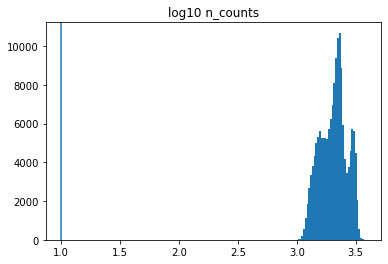

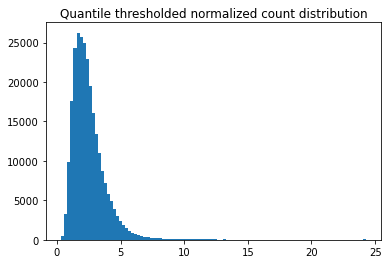

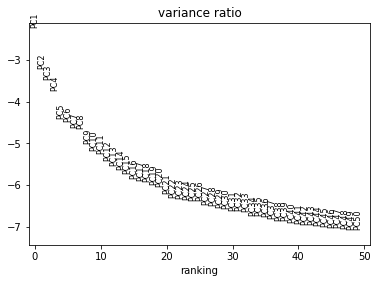

2024-03-13 12:41:44,784 - harmonypy - INFO - Iteration 1 of 20
2024-03-13 12:46:13,467 - harmonypy - INFO - Iteration 2 of 20
2024-03-13 12:49:56,873 - harmonypy - INFO - Iteration 3 of 20
2024-03-13 12:53:46,113 - harmonypy - INFO - Converged after 3 iterations
/PHShome/mc1070/anaconda3/envs/cnmf_env2v2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:524: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[key_n_counts] = counts_per_cell


In [12]:
if params['feature_type_col'] is not None:
    adata_RNA = adata[:, adata.var[params['feature_type_col']]!=params['adt_feature_name']]
    adata_ADT = adata[:, adata.var[params['feature_type_col']]==params['adt_feature_name']]
    
    adata_ADT.var_names_make_unique()
    adata_ADT.var['features_renamed'] = adata_ADT.var.index
    
else:
    adata_RNA = adata
    
adata_RNA.var_names_make_unique()
adata_RNA.var['features_renamed'] = adata_RNA.var.index

p = Preprocess(params['random_seed'])


adata_RNA = p.filter_adata(adata_RNA, filter_mito_thresh=params['filter_mito_thresh'], min_cells_per_gene = params['min_cells_per_RNA_gene'],
             min_counts_per_cell = params['min_rna_counts_per_cell'], filter_mito_genes = params['filter_mito_genes'],
             filter_dot_genes = params['filter_dot_genes'], makeplots=True)
adata_ADT = adata_ADT[adata_RNA.obs.index, :]

(adata_RNA_c, adata_tp10k, hvgs) = p.preprocess_for_cnmf([adata_RNA, adata_ADT], harmony_vars=params['harmony_vars'], n_top_rna_genes = params['n_top_rna_genes'],
                            librarysize_targetsum= 1e4, max_scaled_thresh = params['max_scaled_thresh'], quantile_thresh = params['quantile_thresh'], makeplots=True)

In [16]:
! pwd

/data/srlab1/TCAT/Analysis/PerDataset/HaoEtAl


In [17]:
paths['RNA_Varnorm_Harmony']

'../../../Data/PerDataset/HaoEtAl/haoetal_pbmc_multimodal.merged.ADTfixed.AllPBMC.20240313.RNA.VarNorm.HVG.HarmonyGeneCorrect.h5ad'

In [18]:
paths['RNA_and_ADT_TP10K']

'../../../Data/PerDataset/HaoEtAl/haoetal_pbmc_multimodal.merged.ADTfixed.AllPBMC.20240313.RNA_and_ADT.TP10K.h5ad'

In [19]:
sc.write(paths['RNA_Varnorm_Harmony'], adata_RNA_c)
sc.write(paths['RNA_and_ADT_TP10K'], adata_tp10k)

Only considering the two last: ['.HarmonyGeneCorrect', '.h5ad'].
Only considering the two last: ['.HarmonyGeneCorrect', '.h5ad'].
Only considering the two last: ['.TP10K', '.h5ad'].
Only considering the two last: ['.TP10K', '.h5ad'].


In [20]:
paths['RNA_HVG_List']

'../../../Data/PerDataset/HaoEtAl/haoetal_pbmc_multimodal.merged.ADTfixed.AllPBMC.20240313.RNA.HVGlist.tsv'

In [21]:
with open(paths['RNA_HVG_List'], 'w') as F:
    F.write('\n'.join(hvgs))

In [ ]:
# sc.pp.neighbors(adata_RNA_c, n_neighbors=params['n_neighbors'], n_pcs=params['n_rna_pcs'], use_rep='X_pca_harmony')
# sc.tl.umap(adata_RNA_c)
# adata_RNA_c.obsm['X_harmony_RNA_UMAP'] = adata_RNA_c.obsm['X_umap']
# sc.tl.leiden(adata_RNA_c, resolution=1)
# sc.pl.embedding(adata_RNA_c, basis='X_harmony_RNA_UMAP', color= params['harmony_vars'] + ['leiden'])

In [26]:
adata_RNA_c.obs.to_csv(paths['Metadata'], sep='\t')

In [25]:
paths['Metadata']

'../../../Data/PerDataset/HaoEtAl/haoetal_pbmc_multimodal.merged.ADTfixed.AllPBMC.20240313.metadata.tsv'

In [27]:
# Filt raw data to cells used for cnmf only 
# adata_RNA_c = sc.read(paths['RNA_Varnorm_Harmony'])
adata_filt = adata[adata_RNA_c.obs.index, ]

In [28]:
adata.shape, adata_RNA_c.shape, adata_filt.shape

((161764, 20957), (161724, 2000), (161724, 20957))

In [29]:
paths['Raw_Filt_For_cNMF']

'../../../Data/PerDataset/HaoEtAl/haoetal_pbmc_multimodal.merged.ADTfixed.AllPBMC.20240313.FiltForcNMF.h5ad'

In [30]:
sc.write(paths['Raw_Filt_For_cNMF'], adata_filt)

Only considering the two last: ['.FiltForcNMF', '.h5ad'].
Only considering the two last: ['.FiltForcNMF', '.h5ad'].
